In [32]:
import warnings
warnings.filterwarnings('ignore')

# Import libraries
import pandas                        as pd
import numpy                         as np
import seaborn                       as sns
import matplotlib.pyplot             as plt
from matplotlib_venn                 import venn2
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words("english"))
import string

In [4]:
# Read in two reddit posts
df1 =pd.read_csv('data/nfl.csv')
df2 =pd.read_csv('data/ncaa.csv')

In [5]:
# Check dataframes shape
df1.shape, df2.shape

((1001, 109), (976, 113))

In [6]:
# Append two dataframe into one for data training
df = pd.concat([df1, df2], axis=0)
df = df.reset_index(drop=True)
df.shape

(1977, 114)

In [7]:
# Rename subreddit column to is_nfl
df.rename(columns = {'subreddit':'is_nfl'}, inplace = True)
# Create label column
df['is_nfl'] = df['is_nfl'].map({'NCAA':0, 'nfl':1})

In [8]:
# Check for baseline score
df['is_nfl'].value_counts(normalize=True).mul(100).round(2)

1    50.63
0    49.37
Name: is_nfl, dtype: float64

In [9]:
# There are so many unusable columns
df.isnull().sum()

approved_at_utc          1977
is_nfl                      0
selftext                 1372
author_fullname            32
saved                       0
                         ... 
crosspost_parent_list    1925
crosspost_parent         1925
poll_data                1970
is_gallery               1973
gallery_data             1973
Length: 114, dtype: int64

In [10]:
# Drop the duplicate rows first
df.drop_duplicates(subset='title', keep='first', inplace=True, ignore_index=True)

In [11]:
# 1977 --> 1611 rows
df.shape

(1611, 114)

In [12]:
# Find complete data columns

# make show_nan dataframe to show Nan in each columns 
show_nan = pd.DataFrame(df.isnull().sum().sort_values(ascending=True))
# show full dataframe
pd.set_option('display.max_columns', None)
show_nan.T

,whitelist_status,created_utc,num_crossposts,allow_live_comments,domain,is_video,wls,author_is_blocked,link_flair_type,is_self,send_replies,gildings,edited,permalink,is_created_from_ads_ui,created,score,subreddit_subscribers,archived,parent_whitelist_status,stickied,visited,treatment_tags,locked,spoiler,url,can_gild,awarders,all_awardings,over_18,pinned,is_crosspostable,no_follow,media_only,can_mod_post,subreddit_id,secure_media_embed,downs,mod_reports,hide_score,name,quarantine,id,upvote_ratio,hidden,subreddit_type,subreddit_name_prefixed,link_flair_richtext,ups,author,total_awards_received,title,clicked,is_original_content,user_reports,gilded,contest_mode,saved,is_reddit_media_domain,num_comments,is_meta,is_robot_indexable,is_nfl,media_embed,pwls,link_flair_text_color,author_flair_type,author_flair_richtext,author_fullname,author_patreon_flair,author_premium,url_overridden_by_dest,author_flair_text_color,author_flair_text,author_flair_css_class,author_flair_template_id,author_flair_background_color,media,secure_media,selftext_html,selftext,link_flair_text,link_flair_css_class,suggested_sort,crosspost_parent_list,crosspost_parent,media_metadata,link_flair_template_id,link_flair_background_color,poll_data,author_cakeday,gallery_data,is_gallery,report_reasons,mod_reason_title,top_awarded_type,category,approved_by,thumbnail,content_categories,call_to_action,mod_note,removed_by_category,banned_by,likes,banned_at_utc,view_count,removed_by,num_reports,distinguished,mod_reason_by,removal_reason,discussion_type,approved_at_utc
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,29,29,29,29,29,558,887,917,919,970,972,1050,1050,1101,1101,1334,1334,1575,1578,1578,1598,1600,1602,1605,1606,1608,1608,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611


### Explore title length

In [13]:
# Scope down to only title column
df_title = df[['title', 'is_nfl']]
type(df_title)

pandas.core.frame.DataFrame

In [14]:
#a new column called title_length that contains the length of each status
df_title['title_length'] = df_title['title'].str.len()

In [18]:
#a new column called title_word_count that contains the number of words in each status
# Instantiate RegExp Tokenizer
tokenizer = RegexpTokenizer(r'\w+')
df_title['title_word_count'] = df_title['title'].str.lower().apply(lambda x: len(tokenizer.tokenize(x)))

In [19]:
#  a new column called title_ave_length that contains the sum of the length of all the words and divide it by the total length of the status
df_title['title_ave_length'] = df_title['title_word_count']/df_title['title_length']
df_title.describe().round(2)

,is_nfl,title_length,title_word_count,title_ave_length
count,1611.00,1611.00,1611.00,1611.00
mean,0.51,87.12,15.38,0.17
std,0.50,66.40,12.32,0.03
min,0.00,3.00,1.00,0.08
25%,0.00,42.00,7.00,0.16
50%,1.00,67.00,12.00,0.17
75%,1.00,107.00,19.00,0.19
max,1.00,308.00,59.00,0.33


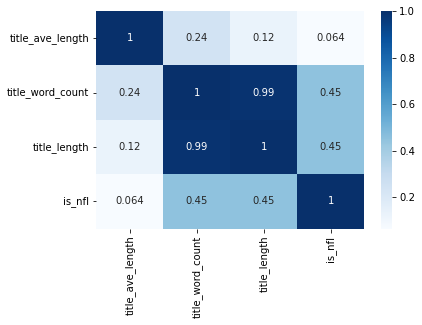

In [20]:
#correlation matrix of 'title_ave_length' 'title_word_count' 'title_length'
df_word = df_title[['title_ave_length','title_word_count','title_length','is_nfl']].copy()
corr = df_word.corr()
sns.heatmap(corr, cmap="Blues", annot=True);

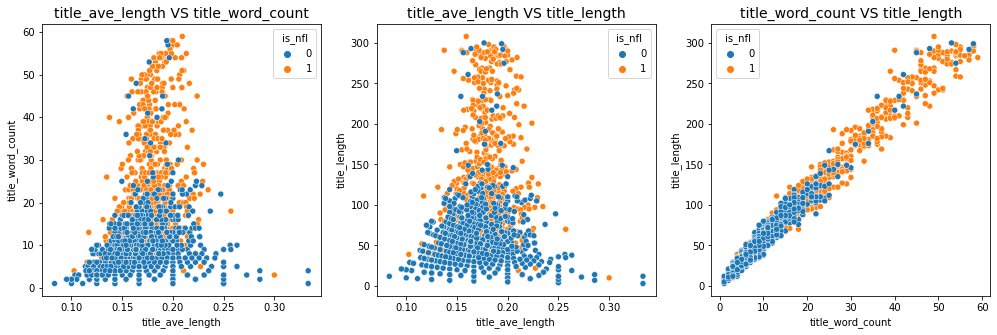

In [21]:
# Visualize df_word
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(17,5))

ax[0].set_title('title_ave_length VS title_word_count', fontsize =14)
sns.scatterplot(ax=ax[0], data=df_word, x='title_ave_length', y='title_word_count', hue='is_nfl')

ax[1].set_title('title_ave_length VS title_length', fontsize =14)
sns.scatterplot(ax=ax[1], data=df_word, x='title_ave_length', y='title_length', hue='is_nfl')

ax[2].set_title('title_word_count VS title_length', fontsize =14)
sns.scatterplot(ax=ax[2], data=df_word, x='title_word_count', y='title_length', hue='is_nfl')

plt.show()



In [22]:
df_word.groupby(['is_nfl'])['title_length','title_word_count','title_ave_length'].agg(['mean']).round(2)

,title_length,title_word_count,title_ave_length
,mean,mean,mean
is_nfl,,,
0,56.64,9.75,0.17
1,116.52,20.80,0.18


In [23]:
# Instantiate a CountVectorizer.
cvec = CountVectorizer(stop_words='english')
# Fit and transform the vectorizer on our corpus.
df_cvec= cvec.fit_transform(df['title'])
df_cvec

<1611x4418 sparse matrix of type '<class 'numpy.int64'>'
	with 14212 stored elements in Compressed Sparse Row format>

In [24]:
# create dataframe for tokens
df_cvec = pd.DataFrame(df_cvec.todense(), columns=cvec.get_feature_names_out())
df_cvec

00  000  02  03  04  04m  06  06m  07  09  10  100  101  103  105  106  \
0      0    0   0   0   0    0   0    0   0   0   0    0    0    0    0    0   
1      0    0   0   0   0    0   0    0   0   0   0    0    0    0    0    0   
2      0    0   0   0   0    0   0    0   0   0   0    0    0    0    0    0   
3      0    0   0   0   0    0   0    0   0   0   0    0    0    0    0    0   
4      0    0   0   0   0    0   0    0   0   0   0    0    0    0    0    0   
...   ..  ...  ..  ..  ..  ...  ..  ...  ..  ..  ..  ...  ...  ...  ...  ...   
1606   0    0   0   0   0    0   0    0   0   0   0    0    0    0    0    0   
1607   0    0   0   0   0    0   0    0   0   0   0    0    0    0    0    0   
1608   0    0   0   0   0    0   0    0   0   0   0    0    0    0    0    0   
1609   0    0   0   0   0    0   0    0   0   0   0    0    0    0    0    0   
1610   0    0   0   0   0    0   0    0   0   0   0    0    0    0    0    0   

      10th  11  112  117  11th  12  124yds  125  12th  13  131  132  139  14  \
0        0   0    0    0     0   0       0    0     0   0    0    0    0   0   
1        0   0    0    0     0   0       0    0     0   0    0    0    0   0   
2        0   0    0    0     0   0       0    0     0   0    0    0    0   0   
3        0   0    0    0     0   0       0    0     0   0    0    0    0   0   
4        0   0    0    0     0   0       0    0     0   0    0    0    0   0   
...    ...  ..  ...  ...   ...  ..     ...  ...   ...  ..  ...  ...  ...  ..   
1606     0   0    0    0     0   0       0    0     0   0    0    0    0   0   
1607     0   0    0    0     0   0       0    0     0   0    0    0    0   0   
1608     0   0    0    0     0   0       0    0     0   0    0    0    0   0   
1609     0   0    0    0     0   0       0    0     0   0    0    0    0   0   
1610     0   0    0    0     0   0       0    0     0   0    0    0    0   0   

      140  144  14m  14th  15  150  16  160  17  171  172  173  176  178  17m  \
0       0    0    0     0   0    0   0    0   0    0    0    0    0    0    0   
1       0    0    0     0   0    0   0    0   0    0    0    0    0    0    0   
2       0    0    0     0   0    0   0    0   0    0    0    0    0    0    0   
3       0    0    0     0   0    0   0    0   0    0    0    0    0    0    0   
4       0    0    0     1   0    0   0    0   0    0    0    0    0    0    0   
...   ...  ...  ...   ...  ..  ...  ..  ...  ..  ...  ...  ...  ...  ...  ...   
1606    0    0    0     0   0    0   0    0   0    0    0    0    0    0    0   
1607    0    0    0     0   0    0   0    0   0    0    0    0    0    0    0   
1608    0    0    0     0   0    0   0    0   0    0    0    0    0    0    0   
1609    0    0    0     0   0    0   0    0   0    0    0    0    0    0    0   
1610    0    0    0     0   0    0   0    0   0    0    0    0    0    0    0   

      18  19  1950  1960s  1970  1973  1985  1987  1988  1989  1990  1991  \
0      0   0     0      0     0     0     0     0     0     0     0     0   
1      0   0     0      0     0     0     0     0     0     0     0     0   
2      0   0     0      0     0     0     0     0     0     0     0     0   
3      0   0     0      0     0     0     0     0     0     0     0     0   
4      0   0     0      0     0     0     0     0     0     0     0     0   
...   ..  ..   ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   
1606   0   0     0      0     0     0     0     0     0     0     0     0   
1607   0   0     0      0     0     0     0     0     0     0     0     0   
1608   0   0     0      0     0     0     0     0     0     0     0     0   
1609   0   0     0      0     0     0     0     0     0     0     0     0   
1610   0   0     0      0     0     0     0     0     0     0     0     0   

      1992  1995  1998  1999  1m  1s  1st  1td  20  200  2000  2000s  2001  \
0        0     0     0     0   0   0    0    0   0    0     0      0     0   
1        0     0     0     0  

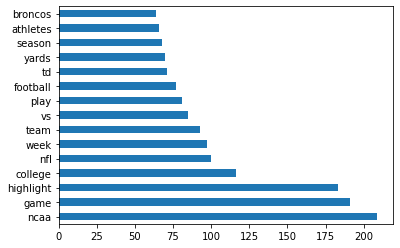

In [25]:
# find most common words
df_cvec.sum().sort_values(ascending =False).head(15).plot.barh();

In [26]:
# Find crossover words

In [27]:
# CounterVectorize NFL and NCAA titles
df1_cvec= cvec.fit_transform(df1['title'])
df1_cvec = pd.DataFrame(df1_cvec.todense(), columns=cvec.get_feature_names_out())
df2_cvec= cvec.fit_transform(df2['title'])
df2_cvec = pd.DataFrame(df2_cvec.todense(), columns=cvec.get_feature_names_out())

In [28]:
freq1 = pd.Series(df1_cvec.sum().sort_values(ascending =False)[:10])
freq1 = list(freq1.index) 
freq1

['highlight',
 'game',
 'nfl',
 'yards',
 'td',
 'week',
 'play',
 'today',
 'broncos',
 'team']

In [29]:
freq2 = pd.Series(df2_cvec.sum().sort_values(ascending =False)[:10])
freq2 = list(freq2.index) 
freq2

['ncaa',
 'college',
 'athletes',
 'football',
 'state',
 'vs',
 'basketball',
 'team',
 'game',
 'eligibility']

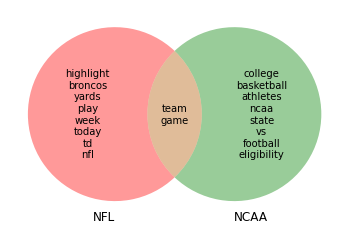

In [30]:
A=set(freq1)
B=set(freq2)
v = venn2([A,B], ('NFL', 'NCAA'))
v.get_label_by_id('100').set_text('\n'.join(A-B))
v.get_label_by_id('110').set_text('\n'.join(A&B))
v.get_label_by_id('010').set_text('\n'.join(B-A))

### Exploring more quantitative properties of text

In [33]:
## Number of words in the text ##
df["num_words"] = df["title"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
df["num_unique_words"] = df["title"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
df["num_chars"] = df["title"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
df["num_stopwords"] = df["title"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
df["num_punctuations"] =df['title'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


## Average length of the words in the text ##
df["mean_word_len"] = df["title"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


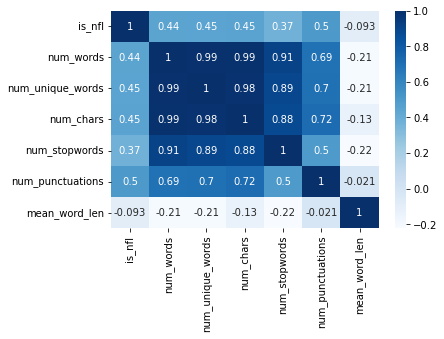

In [40]:
#correlation matrix of 'title_ave_length' 'title_word_count' 'title_length'
df_word = df[['is_nfl','num_words', 'num_unique_words',
       'num_chars', 'num_stopwords', 'num_punctuations', 'mean_word_len']].copy()
corr = df_word.corr()
sns.heatmap(corr, cmap="Blues", annot=True);


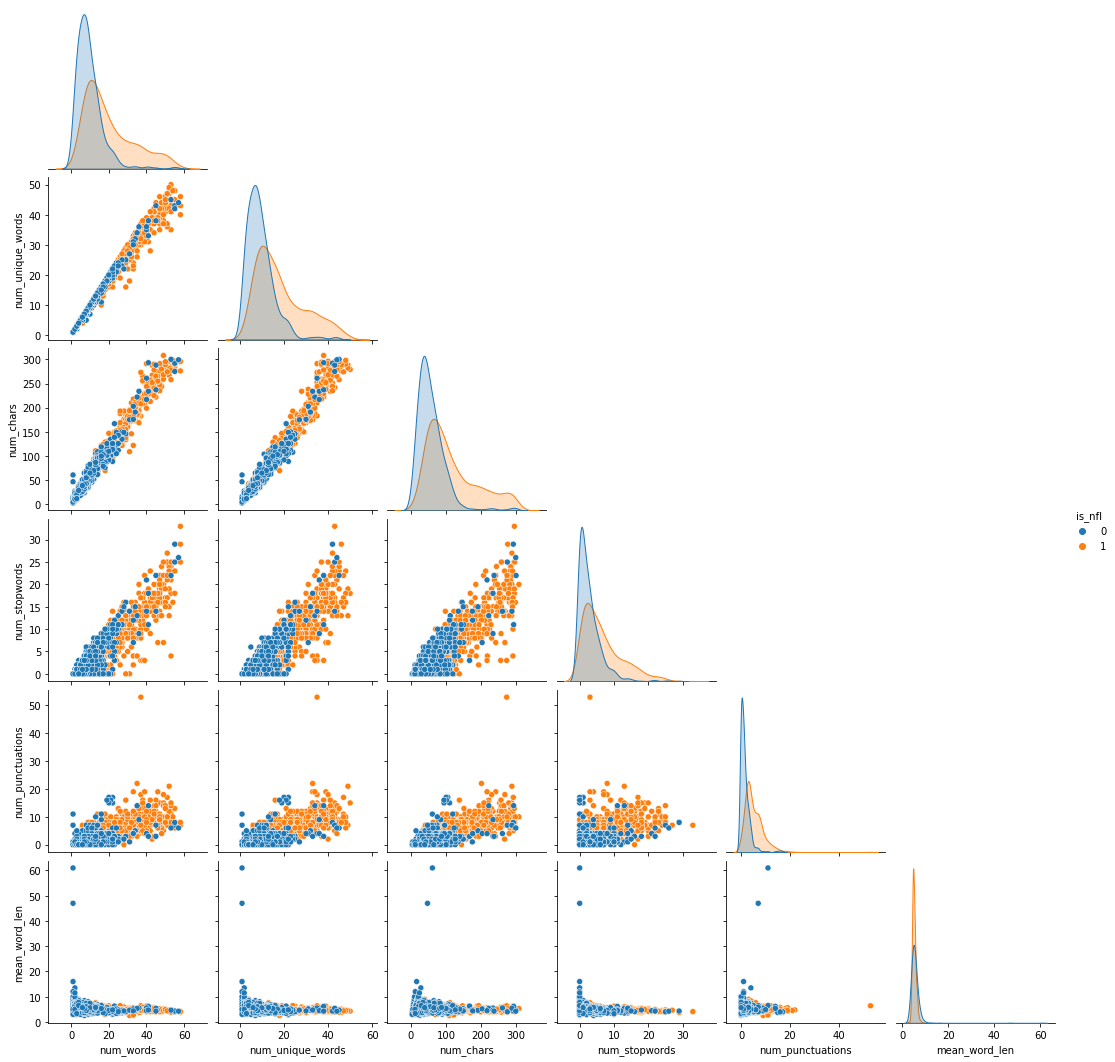

In [44]:
sns.pairplot(df_word, hue='is_nfl', corner=True);

In [42]:
df_word.groupby('is_nfl').agg(['mean']).round(2)

,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
,mean,mean,mean,mean,mean,mean
is_nfl,,,,,,
0,9.56,9.27,56.64,2.75,1.46,5.43
1,20.13,18.46,116.52,6.58,5.17,5.05
